In [1]:
import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import cv2
import keras.backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
training_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [3]:
# This code seperates the whole training set into train, validation, adn test sets. The validation set provided does not contain masks.

# NOTE: Training set 355 is discarded due to its weird file name
directories = sorted([
    f.path.split('/')[-1] for f in os.scandir(training_path) if f.is_dir()
    if not f.path.endswith('BraTS20_Training_355')
])

train_set, val_set = train_test_split(directories, test_size=0.3, random_state=42)
train_set, test_set = train_test_split(train_set, test_size=0.1, random_state=42)

train_set = train_set[0 : len(train_set) // 2]
val_set = val_set[0 : len(val_set) // 2]
test_set = test_set[0 : len(test_set) // 2]

In [13]:
'''
This is a DataGenerator class that overrides the keras data generator
'''
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_IDs, dim=(128,128), batch_size=1, n_channels=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_name = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(batch_name)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_name):
        X = np.zeros((self.batch_size*100, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*100, 240, 240))

        for idx, name in enumerate(batch_name):
            #print(f"Processing sample {name}")
            # Load the NifTi files using nibabel library
            folder = os.path.join(training_path, name)
            flair = nib.load(os.path.join(folder, f'{name}_flair.nii')).get_fdata()    
            t1ce = nib.load(os.path.join(folder, f'{name}_t1ce.nii')).get_fdata()
            t2 = nib.load(os.path.join(folder, f'{name}_t2.nii')).get_fdata()
            mask = nib.load(os.path.join(folder, f'{name}_seg.nii')).get_fdata()

            # Resize each image into 128 * 128 insert each slice (a total of 100 slices)
            for slice_num in range(100):
                X[slice_num + 100 * idx, :, :, 0] = cv2.resize(flair[:, :, slice_num], (128, 128))
                X[slice_num + 100 * idx, :, :, 1] = cv2.resize(t1ce[:, :, slice_num], (128, 128))
                X[slice_num + 100 * idx, :, :, 2] = cv2.resize(t2[:, :, slice_num], (128, 128))
                y[slice_num + 100 * idx] = mask[:, :, slice_num]

        # Since Label 3 is missing, reassign label 4 to 3
        y[y==4] = 3
        y = to_categorical(y, num_classes = 4)
        y = tf.image.resize(y, (128, 128))
        
        # Normalization
        return X / np.max(X), y

In [10]:
'''
This is the dice coeffecient metric for a total 4 labels, each label are assigned the same weight
'''
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

'''
This is a dice loss function for the Unet model
'''
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return keras.losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [11]:
'''
This is a UNet model for image segmentation. The contraction path has 5 stacks of convolution and max pooling layers, 
with a dropout layer in between the convolution layers. The expansion path has matching stacks of transposed 
convolutions. The output layer is a convolution layer with a softmax activation. 
'''
def unet(inputs, ker_init):
    
    # Down Sampling Procedure
    c1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(c5)

    # Up Sampling Procedure
    u6 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(c5)
    u6 = concatenate([c4,u6], axis = 3)
    c6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(c6)

    u7 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(c6)
    u7 = concatenate([c3,u7], axis = 3)
    c7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(c7)

    u8 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(c7)
    u8 = concatenate([c2,u8], axis = 3)
    c8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(c8)
    
    u9 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(c8)
    u9 = concatenate([c1,u9], axis = 3)
    c9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(c9)
    
    c10 = Conv2D(4, (1,1), activation = 'softmax')(c9)
    
    model = Model(inputs = inputs, outputs = c10)
    
    model.summary()
    
    return model


model = unet(Input((128, 128, 3)), 'he_normal')
model.compile(loss=combined_loss, 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef]
             )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 32  0           ['conv2d_19[0][0]']              
                                )                                                           

In [68]:
training_generator = DataGenerator(train_set)
valid_generator = DataGenerator(val_set)
test_generator = DataGenerator(test_set)


# history =  model.fit(training_generator,
#                     epochs=20,
#                     steps_per_epoch=len(train_set),
#                     verbose = 1,
#                     validation_data = valid_generator,
#                     )  

# model.save("/kaggle/working/epoch20_lr0.001_dice_he.h5")

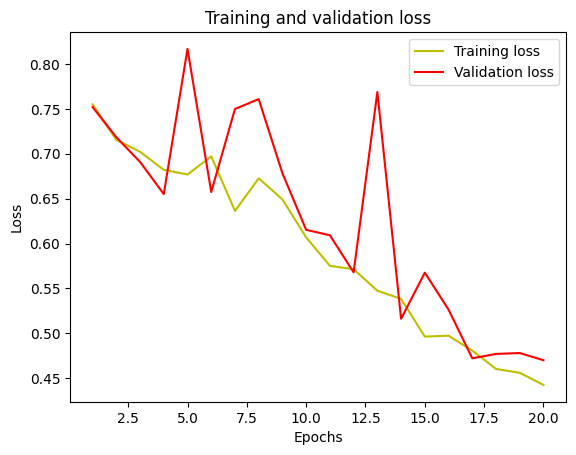

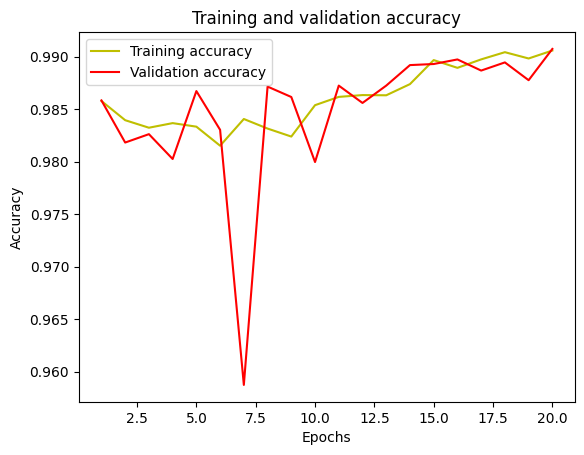

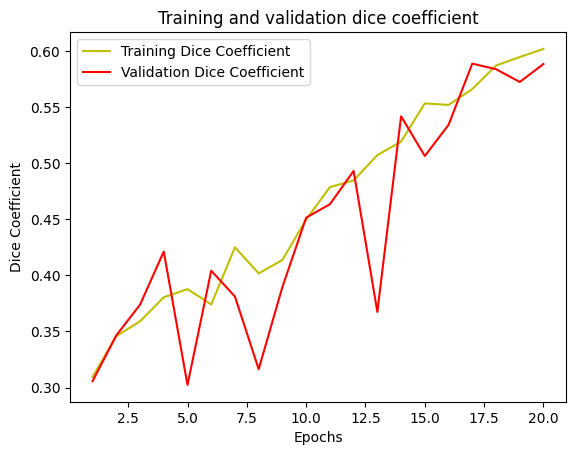

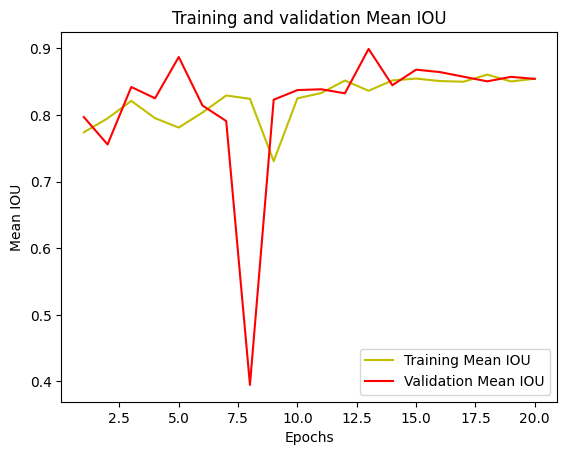

In [15]:
# Visualization Code

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

plt.plot(epochs, dice_coef, 'y', label='Training Dice Coefficient')
plt.plot(epochs, val_dice_coef, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

mean_io_u = history.history['mean_io_u_1']
val_mean_io_u = history.history['val_mean_io_u_1']

plt.plot(epochs, mean_io_u, 'y', label='Training Mean IOU')
plt.plot(epochs, val_mean_io_u, 'r', label='Validation Mean IOU')
plt.title('Training and validation Mean IOU')
plt.xlabel('Epochs')
plt.ylabel('Mean IOU')
plt.legend()
plt.show()


In [18]:
# Evaluation the model
evaluation = model.evaluate(test_generator,
                            batch_size = len(test_set),
                            verbose = 1
                           )
print(evaluation)
print('Testing Loss: ' + str(evaluation[0]))
print('Testing Accuracy: ' + str(evaluation[1]))
print('Testing Mean IOU: ' + str(evaluation[2]))
print('Testing Dice Coefficient: ' + str(evaluation[3]))

13/13 [==============================] - 7s 536ms/step - loss: 0.5438 - accuracy: 0.9893 - mean_io_u_1: 0.8516 - dice_coef: 0.5351
[0.5438479781150818, 0.9892506003379822, 0.8515552282333374, 0.535112738609314]
Testing Loss: 0.5438479781150818
Testing Accuracy: 0.9892506003379822
Testing Mean IOU: 0.8515552282333374
Testing Dice Coefficient: 0.535112738609314


In [64]:
# Prediction
X = np.zeros((100, 128, 128, 3))
set_num = '001'
test_flair = nib.load('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_' + set_num +'/BraTS20_Training_'+set_num +'_flair.nii').get_fdata() 
test_t1ce = nib.load('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_' + set_num +'/BraTS20_Training_'+set_num +'_t1ce.nii').get_fdata()
test_t2 = nib.load('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_' + set_num +'/BraTS20_Training_'+set_num +'_t2.nii').get_fdata()
mask = nib.load('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_' + set_num +'/BraTS20_Training_'+set_num +'_seg.nii').get_fdata()
for slice_num in range(100):
    X[slice_num, :, :, 0] = cv2.resize(test_flair[:, :, slice_num], (128, 128))
    X[slice_num, :, :, 1] = cv2.resize(test_t1ce[:, :, slice_num], (128, 128))
    X[slice_num, :, :, 2] = cv2.resize(test_t2[:, :, slice_num], (128, 128))

mask = mask.astype(np.uint8)
mask[mask==4] = 3
prediction = model.predict(X/np.max(X), verbose=1)




4/4 [==============================] - 0s 41ms/step


<class 'numpy.ndarray'>
(100, 128, 128)


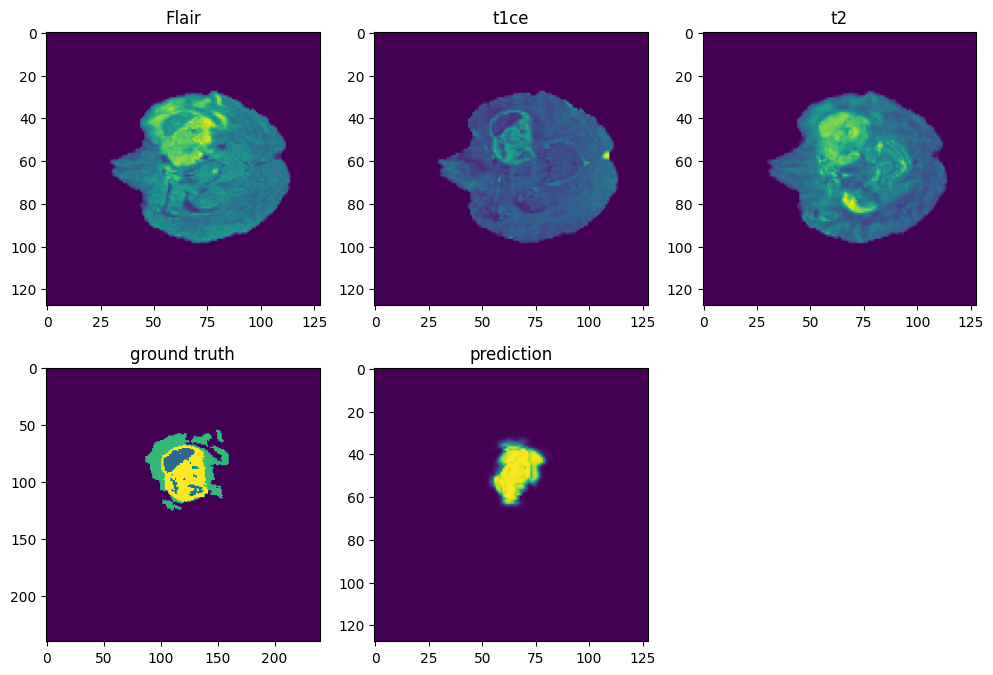

In [67]:
SLICE = 67
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Flair')
plt.imshow(X[55, :, :, 0])
plt.subplot(232)
plt.title('t1ce')
plt.imshow(X[55, :, :, 1])
plt.subplot(233)
plt.title('t2')
plt.imshow(X[55, :, :, 2])

plt.subplot(234)
plt.title('ground truth')
plt.imshow(mask[ :, :, 55])

img_1 = prediction[:,:,:,1]
img_2 = prediction[:,:,:,2]
img_3 = prediction[:,:,:,3]

combined = img_1 + img_2 + img_3
#combined = combined / np.max(combined)

print(type(label_1))
print(label_1.shape)
plt.subplot(235)
plt.title('prediction')
plt.imshow(combined[55, :, :])
